In [1]:
import os
import time
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from utils import show_image
from matplotlib.patches import Rectangle

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [3]:
import tensorflow as tf
import tensorflow_hub as hub

In [4]:
%matplotlib inline

Initialize bg subtraction object

In [5]:
fgbg_1 = cv2.createBackgroundSubtractorMOG2(detectShadows=False, history=50, varThreshold=16)
fgbg_2 = cv2.createBackgroundSubtractorMOG2(detectShadows=False, history=50, varThreshold=8)
fgbg_3 = cv2.createBackgroundSubtractorKNN(detectShadows=False, history=50)

Test on a stream

TODO: https://www.vegvesen.no/trafikkinformasjon/reiseinformasjon/Trafikkmeldinger/Webkamera#/vis/751511/video

In [6]:
STREAM = 'https://kamera.vegvesen.no/public/0229004_1/hls_1_stream_1_orig.m3u8'

In [7]:
vstream = None
fg = [[], [], []]
bg = None
cnt = 0
try:
    print("Started Video Stream")
    vstream = cv2.VideoCapture(STREAM)
    while True:
        ret, frame = vstream.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)            
            frame = frame[120:, 0:550, :] # Region Cropping.
            bg = frame.copy()
            fg[0].append(fgbg_1.apply(frame.copy()))
            fg[1].append(fgbg_2.apply(frame.copy()))
            fg[2].append(fgbg_3.apply(frame.copy()))
            cnt += 1
            print('Processed Frame', cnt)
        time.sleep(0.25)
except:
    print("Stopped Video Stream")
finally:
    vstream.release()

Started Video Stream
Processed Frame 1
Processed Frame 2
Processed Frame 3
Processed Frame 4
Processed Frame 5
Processed Frame 6
Processed Frame 7
Processed Frame 8
Processed Frame 9
Processed Frame 10
Processed Frame 11
Processed Frame 12
Processed Frame 13
Processed Frame 14
Processed Frame 15
Processed Frame 16
Processed Frame 17
Processed Frame 18
Processed Frame 19
Processed Frame 20
Processed Frame 21
Processed Frame 22
Processed Frame 23
Processed Frame 24
Processed Frame 25
Processed Frame 26
Processed Frame 27
Processed Frame 28
Processed Frame 29
Processed Frame 30
Processed Frame 31
Processed Frame 32
Processed Frame 33
Processed Frame 34
Processed Frame 35
Processed Frame 36
Processed Frame 37
Processed Frame 38
Processed Frame 39
Processed Frame 40
Processed Frame 41
Processed Frame 42
Processed Frame 43
Processed Frame 44
Processed Frame 45
Processed Frame 46
Processed Frame 47
Processed Frame 48
Processed Frame 49
Processed Frame 50
Processed Frame 51
Processed Frame 52


In [7]:
# Override ...
bg = cv2.imread('../images/temp/bgsub.png', cv2.IMREAD_COLOR)
fg = [[None], [None], [None]]
fg[-1][-1] = cv2.imread('../images/temp/knn.png', cv2.IMREAD_GRAYSCALE)

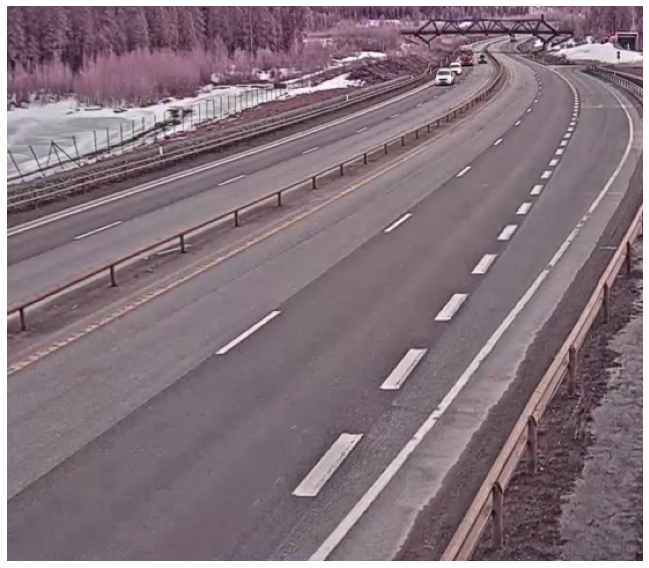

In [103]:
show_image(bg)

Extract objects

In [104]:
def blur(src, size):
    return cv2.blur(src, size)

def box_blur(src, size, normalize=False):
    return cv2.boxFilter(src, src.shape[-1], size, normalize=normalize)

def median_blur(src, value=5):
    return cv2.medianBlur(src, value)

def gaussian_blur(src, size, sigmaX=0, sigmaY=0):
    return cv2.GaussianBlur(src, size, sigmaX, sigmaY)

def bilateral_filter(src, diameter, sigmaCol, sigmaSpace):
    return cv2.bilateralFilter(src, diameter, sigmaCol, sigmaSpace)

In [105]:
def extract_foreground(src, fn=None):
    src = src.copy()
    if fn:
        src = fn(src)
    
    kernel1 = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    kernel2 = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (6,6))
    kernel4 = cv2.getStructuringElement(cv2.MORPH_RECT, (7,7))
    
    dilate = cv2.morphologyEx(src, cv2.MORPH_DILATE, kernel1)
    closing = cv2.morphologyEx(dilate, cv2.MORPH_CLOSE, kernel2)
    erosion = cv2.morphologyEx(closing, cv2.MORPH_ERODE, kernel3)
    opening = cv2.morphologyEx(erosion, cv2.MORPH_OPEN, kernel4)
    
    return opening, (opening > 0).astype(int)

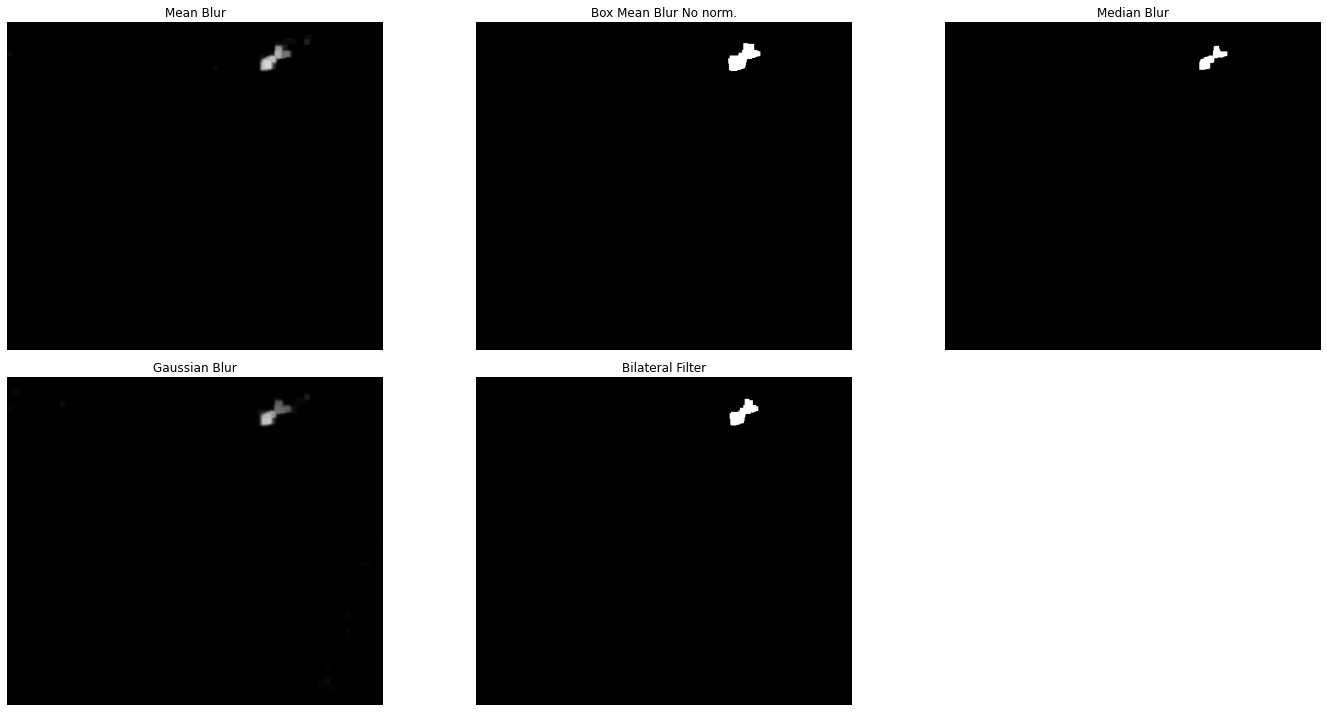

In [106]:
src = fg[-1][-1]
IMG1, _ = extract_foreground(src, fn=lambda x: blur(x, (5,5)))
IMG2, _ = extract_foreground(fg[-1][-1], fn=lambda x: box_blur(x, (5,1)))
IMG3, _ = extract_foreground(fg[-1][-1], fn=lambda x: median_blur(x,3))
IMG4, _ = extract_foreground(fg[0][-1], fn=lambda x: gaussian_blur(x, (9,9), 0))
IMG5, _ = extract_foreground(fg[-1][-1], fn=lambda x: bilateral_filter(x, 9, 50, 50))

plt.figure(figsize=(20,10))

ax = plt.subplot(231)
plt.imshow(IMG1, cmap='gray', vmin=0, vmax=255)
plt.xticks([]),plt.yticks([])
plt.title('Mean Blur')
ax.axis("off")

ax = plt.subplot(232)
plt.imshow(IMG2, cmap='gray', vmin=0, vmax=255)
plt.xticks([]),plt.yticks([])
plt.title('Box Mean Blur No norm.')
ax.axis("off")

ax = plt.subplot(233)
plt.imshow(IMG3, cmap='gray', vmin=0, vmax=255)
plt.xticks([]),plt.yticks([])
plt.title('Median Blur')
ax.axis("off")

ax = plt.subplot(234)
plt.imshow(IMG4, cmap='gray', vmin=0, vmax=255)
plt.xticks([]),plt.yticks([])
plt.title('Gaussian Blur')
ax.axis("off")

ax = plt.subplot(235)
plt.imshow(IMG5, cmap='gray', vmin=0, vmax=255)
plt.xticks([]),plt.yticks([])
plt.title('Bilateral Filter')
ax.axis("off")

plt.tight_layout()
plt.savefig('../images/temp/filtercomparison.png')
plt.show()

In [107]:
def detect_objects(bg, fg, min_size=10, thresh=0.5):    
    for v in [1, 3, 5, 7, 9]: # Try various blur values.
        I, _ = extract_foreground(fg, fn=lambda x: median_blur(x, v))
        cnt, _ = cv2.findContours(I, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        if len(cnt) == 0:
            continue
        
        images, reasonable_objects = [], 0
        for obj in cnt:
            obj = obj.reshape(-1,2)
            x, y = [v[0] for v in obj], [v[1] for v in obj]
            x_min, x_max = min(x), max(x)
            y_min, y_max = min(y), max(y)            
            size = min((x_max - x_min), (y_max - y_min))
            if size >= min_size:
                reasonable_objects += 1
                images.append(bg[y_min:y_max, x_min:x_max, :].copy())
        
        if (reasonable_objects / len(cnt)) >= thresh:
            return images
        
    return []

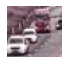

In [111]:
for img in detect_objects(bg, fg[-1][-1]):
    show_image(img, size=(2,1))

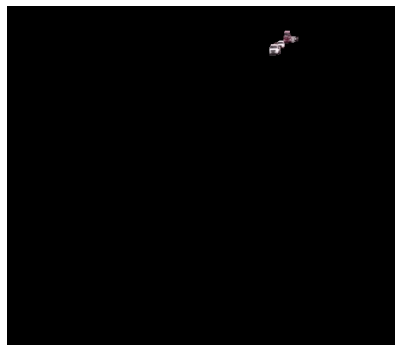

In [113]:
I, mask = extract_foreground(fg[-1][-1], fn=lambda x: median_blur(x,3))
t = bg.copy()
for i in range(3):
    t[:,:,i] = mask*t[:,:,i]
show_image(t, size=(8,5))

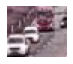

In [99]:
cnt, _ = cv2.findContours(I, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
coords = []
for obj in cnt:
    obj = obj.reshape(-1,2)
    x, y = [v[0] for v in obj], [v[1] for v in obj]
    x_min, x_max = min(x), max(x)
    y_min, y_max = min(y), max(y)
    coords.append((x_min,y_min, x_max,y_max))
    show_image(bg[y_min:y_max, x_min:x_max, :], size=(2,1))

In [100]:
def draw_bboxes(ax):
    for xmin, ymin, xmax, ymax in coords:
        ax.add_patch(Rectangle(
            (xmin, ymin),
            (xmax-xmin),
            (ymax-ymin),
            linewidth=1, edgecolor='r', facecolor='none'
        ))

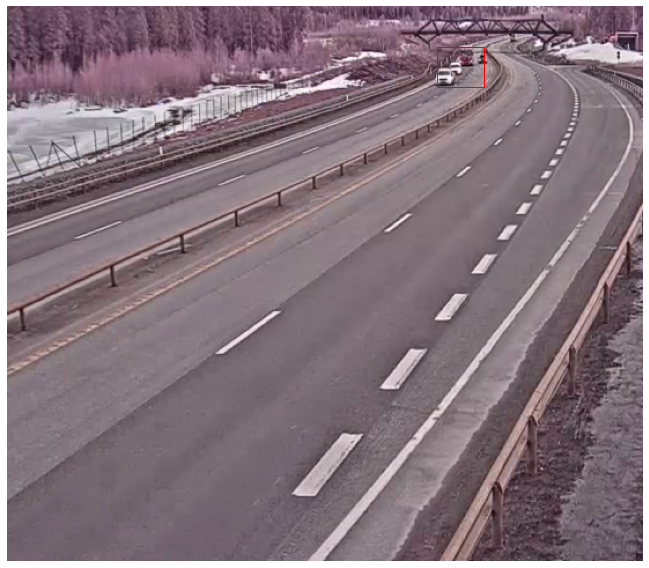

In [71]:
show_image(bg, fn=draw_bboxes)

Load image classifier + do inference

In [114]:
LBLS = ['bike', 'bus', 'car', 'person', 'truck']

In [115]:
def predict(mdl, src, target_size=224):
    src = (cv2.resize(src, (target_size, target_size)) / 255.0) # Resize and normalize to allow prediction @ mdl.
    return LBLS[np.argmax(mdl(np.expand_dims(src, axis=0), training=False))]

In [116]:
model = tf.keras.models.load_model('../exported-models/mobilenet')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              4226432   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 4,232,837
Trainable params: 4,208,437
Non-trainable params: 24,400
_________________________________________________________________


In [123]:
for obj in cnt:
    obj = obj.reshape(-1,2)
    x, y = [v[0] for v in obj], [v[1] for v in obj]
    x_min, x_max = min(x), max(x)
    y_min, y_max = min(y), max(y)
    src = bg[y_min:y_max, x_min:x_max, :].copy()
    v = time.time()
    print(predict(model, src, 224))
    print('Prediction took: {:.04f} sec.'.format(time.time()-v))

car
Prediction took: 0.0670 sec.


In [122]:
start_time = time.time()
for img in detect_objects(bg, fg[-1][-1]):
    print(predict(model, img, 224))
print('Detection took: {:.04f} sec.'.format(time.time()-start_time))

car
Detection took: 0.0660 sec.
